In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import schedules

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, recall_score, precision_score, f1_score, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


2024-01-16 20:48:13.774866: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 20:48:14.054276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 20:48:14.054361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 20:48:14.084382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 20:48:14.167141: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-16 20:48:14.170008: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
BASE_PATH = 'data/ROSMAP/'
methy_path = os.path.join(BASE_PATH,'methy.csv')
mirna_path = os.path.join(BASE_PATH,'mirna.csv')
mrna_path = os.path.join(BASE_PATH,'mrna.csv')
if not os.path.exists(methy_path) or not os.path.exists(mirna_path) or not os.path.exists(mrna_path):
    raise Exception('File not exists!')

In [4]:
methy_df = pd.read_csv(methy_path, index_col=0)
mirna_df = pd.read_csv(mirna_path, index_col=0)
mrna_df = pd.read_csv(mrna_path, index_col=0)
print(methy_df.shape, mirna_df.shape, mrna_df.shape)

(351, 202) (351, 202) (351, 202)


In [4]:
methy_df_wol = methy_df.drop('Label', axis=1)
mirna_df_wol = mirna_df.drop('Label', axis=1)
mrna_df_wol = mrna_df.drop('Label', axis=1)
methy_df_wos = methy_df_wol.drop('Split', axis=1)
mirna_df_wos = mirna_df_wol.drop('Split', axis=1)
mrna_df_wos = mrna_df_wol.drop('Split', axis=1)

combined_df = pd.concat([methy_df_wos, mirna_df_wos, mrna_df_wos], axis=1)
combined_df['Label'] = methy_df['Label']
combined_df['Split'] = methy_df['Split']

In [5]:
def get_train_test(df):
    train_df = df[df['Split'] == 1].drop('Split', axis=1)
    test_df = df[df['Split'] == 0].drop('Split', axis=1)
    y_train = train_df.pop('Label')
    y_test = test_df.pop('Label')
    return train_df, test_df, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = get_train_test(combined_df)

In [7]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Accuracy:  0.8584905660377359
# F1 score:  0.8571428571428572
# Recall:  0.8181818181818182
# Precision:  0.9
# Cohen Kappa:  0.7175843694493784
# Matthews Corr:  0.7207853001714266

In [8]:
# from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Accuracy:  0.7924528301886793
# F1 score:  0.7962962962962964
# Recall:  0.7818181818181819
# Precision:  0.8113207547169812
# Cohen Kappa:  0.5849056603773585
# Matthews Corr:  0.5853225568382547


In [9]:
# from sklearn.preprocessing import MaxAbsScaler

# scaler = MaxAbsScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Accuracy:  0.7358490566037735
# F1 score:  0.6956521739130435
# Recall:  0.5818181818181818
# Precision:  0.8648648648648649
# Cohen Kappa:  0.4776487152411123
# Matthews Corr:  0.5070934576494096


In [10]:
# from sklearn.preprocessing import QuantileTransformer

# scaler = QuantileTransformer(output_distribution='uniform')
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# Accuracy:  0.7924528301886793
# F1 score:  0.8035714285714286
# Recall:  0.8181818181818182
# Precision:  0.7894736842105263
# Cohen Kappa:  0.5837200999642984
# Matthews Corr:  0.5841385339486312

In [11]:
min_max_scaler = StandardScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [12]:
input_shape = X_train_scaled.shape[1]
input_layer = Input(shape=input_shape,)

In [13]:
    # Define your ANN model architecture here
#TODO: 1. use optuna to find the best hyperparameters

dense_layer1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(input_layer) #153
dropout_layer1 = Dropout(0.3)(dense_layer1)
batch_norm1 = tf.keras.layers.BatchNormalization()(dropout_layer1)

dense_layer2 = Dense(64, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(batch_norm1) #104
dropout_layer2 = Dropout(0.3)(dense_layer2)
batch_norm2 = tf.keras.layers.BatchNormalization()(dropout_layer2)

dense_layer3 = Dense(32, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(batch_norm2) #42
dropout_layer3 = Dropout(0.3)(dense_layer3)
batch_norm3 = tf.keras.layers.BatchNormalization()(dropout_layer3)

dense_layer4 = Dense(16, activation='relu', kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001))(batch_norm3) #16
dropout_layer4 = Dropout(0.3)(dense_layer4)

output_layer = Dense(1, activation='sigmoid')(dropout_layer4)

model = Model(inputs=input_layer, outputs=output_layer)

2024-01-16 12:08:48.809449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [14]:
initial_learning_rate = 0.001
lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

In [15]:
#compiling the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [17]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [18]:
history = model.fit(X_train_split, y_train_split, epochs=500, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/500


4/4 [==============================] - 2s 103ms/step - loss: 1.2126 - accuracy: 0.4847 - val_loss: 1.1265 - val_accuracy: 0.4898
Epoch 2/500
4/4 [==============================] - 0s 15ms/step - loss: 1.1324 - accuracy: 0.5510 - val_loss: 1.1085 - val_accuracy: 0.4694
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1071 - accuracy: 0.5612 - val_loss: 1.0999 - val_accuracy: 0.4898
Epoch 4/500
4/4 [==============================] - 0s 15ms/step - loss: 1.0816 - accuracy: 0.5408 - val_loss: 1.0908 - val_accuracy: 0.4898
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 1.0874 - accuracy: 0.5816 - val_loss: 1.0842 - val_accuracy: 0.4694
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 1.0535 - accuracy: 0.5714 - val_loss: 1.0783 - val_accuracy: 0.4898
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 1.1007 - accuracy: 0.5204 - val_loss: 1.0729 - val_accuracy: 0.4898
Epoch 8/500
4/4 [==============

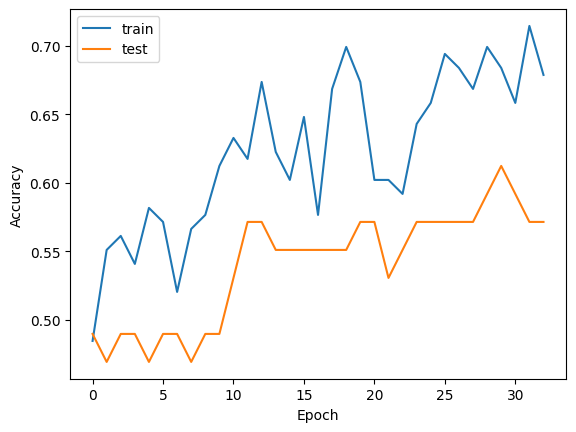

In [19]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [20]:
y_pred = model.predict(X_test_scaled)
y_pred_class = np.where(y_pred > 0.5, 1, 0)
print('Accuracy: ', accuracy_score(y_test, y_pred_class))
print('F1 score: ', f1_score(y_test, y_pred_class))
print('Recall: ', recall_score(y_test, y_pred_class))
print('Precision: ', precision_score(y_test, y_pred_class))
print('Cohen Kappa: ', cohen_kappa_score(y_test, y_pred_class))
print('Matthews Corr: ', matthews_corrcoef(y_test, y_pred_class))


4/4 [==============================] - 0s 2ms/step
Accuracy:  0.660377358490566
F1 score:  0.6538461538461539
Recall:  0.6181818181818182
Precision:  0.6938775510204082
Cohen Kappa:  0.3226837060702875
Matthews Corr:  0.32475958859896376
